In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [71]:
# build the dataset 
block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


In [72]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [143]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [147]:
C = torch.randn((27, 2))

In [21]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [22]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [42]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [43]:
h

tensor([[ 0.9957,  0.8981, -0.9945,  ..., -1.0000, -0.9999, -0.9631],
        [ 0.1138,  0.1416, -1.0000,  ..., -0.9861, -0.9996, -0.9708],
        [ 1.0000,  0.9991,  0.9766,  ...,  0.8310, -0.7614,  0.8064],
        ...,
        [-0.1262, -0.0499, -0.9942,  ..., -0.9580, -0.9682, -0.9153],
        [ 0.9978,  0.9685, -0.0832,  ...,  0.5713, -0.6588,  0.2312],
        [-0.9904, -0.5048, -0.9922,  ...,  0.9628,  0.7104, -0.9756]])

In [44]:
h.shape

torch.Size([32, 100])

In [45]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)



In [46]:
logits = h @ W2 + b2

In [47]:
logits.shape

torch.Size([32, 27])

In [48]:
counts = logits.exp()

In [49]:
prob = counts / counts.sum(1, keepdims=True)

In [50]:
prob.shape

torch.Size([32, 27])

In [55]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.3951)

In [56]:
# ------ more clean code ------

In [152]:
Xtr.shape, Ytr.shape # dataset
Xdev.shape, Ydev.shape # dataset
Xte.shape, Yte.shape # dataset

(torch.Size([22866, 3]), torch.Size([22866]))

In [191]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [192]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [193]:
for p in parameters:
    p.requires_grad = True

In [194]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [195]:
lri = []
lossi = []
stepi = []

In [205]:

for i in range(50000):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
            
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


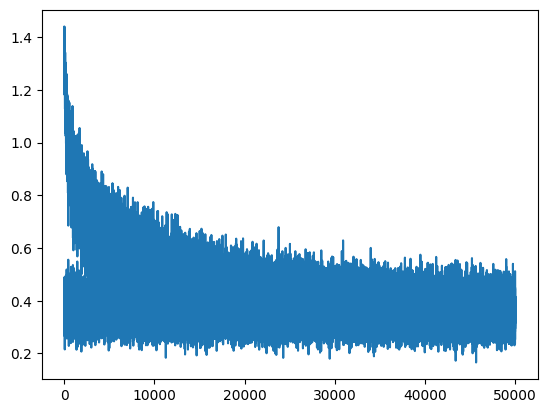

In [206]:
plt.plot(stepi, lossi)

In [207]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2820, grad_fn=<NllLossBackward0>)

In [208]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2936, grad_fn=<NllLossBackward0>)

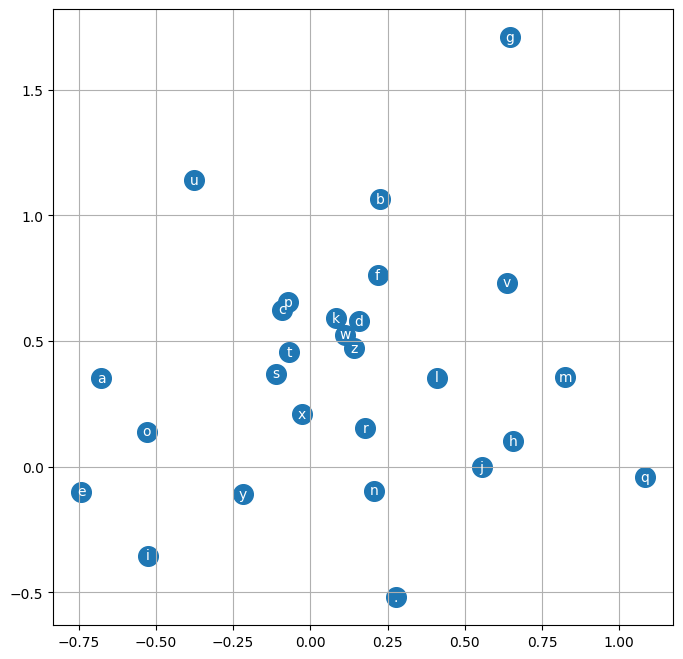

In [190]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [209]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) # for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all .. 
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

cartah.
amille.
khiim.
sire.
tyah.
cassa.
jazonen.
amerric.
kaeli.
nelenia.
chaiir.
kaleigph.
lus.
kin.
quint.
sroj.
waivan.
quinaelogiearynix.
kaerlinsa.
mel.
